<a href="https://www.kaggle.com/code/killianmcguinness/data-visualisation-call-center-kpis?scriptVersionId=164988287" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# KPI Visualization for Contact Centers

## Objective:
Leverage a common call center dataset to craft visually engaging visualizations that shed light on the operational efficiency and effectiveness of the contact center. This project will delve into fundamental metrics and concepts pivotal in call center management. Before jumping in we deal with some common KPIs I want to define. 

- **CAR (Call Acceptance/Abandon Rate):**
  - Definition: Volume of calls answered before the caller hangs up.

- **SLA (Service Level Agreement):**
  - Definition: Volume of calls answered within the agreed timeframe.

- **Concurrency:**
  - Definition: Amount of calls occurring simultaneously.

- **Capacity:**
  - Definition: The volume of calls that the actual number of agents can handle.

- **Handle Times:**
  - Definition: Average duration to manage a call type.


## About The Data:
This dataset comprises typical call center data sourced from the City of Cincinnati, Ohio's Citizen's Information Centre. It specifically focuses on incoming calls to the contact center, representing information commonly exported from a Customer Relationship Management (CRM) or Soft-phone service.

**Period:**
October 1st 2022 tth December 31st 2022 (Q4 2022). 

This project aims to present a visually engaging overview of call center performance metrics, providing valuable insights into the efficiency and effectiveness of the contact center operations.


| Step | Objective |
|------|-----------|
| 1    | Read in CSV data & make it easier to work with. |
| 2    | Calculate CAR (Call Acceptance Rate) and SLA (Service Level Agreement). |
| 3    | Visualise CAR & SLA performance using Dataframes. |
| 4    | Analyze Call Concurrency and Agent Capacity. |
| 5    | Building HeatMaps for better visualization. |
| 6    | Refine data for Call Arrival Patterns & Average Handle Times. |
| 7    | Forecast 12 Months Calls volumes using Time Series Model. |

# Step 1: Data Preparation 🛠️
### Objective: Read in CSV data & make it easier to work with. <br>

**1. Import Key Libraries:**
- Import necessary libraries for data manipulation and visualization.

**2. Data Loading & Cleaning:**
- Read a call center dataset from a CSV file, focusing on relevant columns. Rename columns for clarity and add date-related features. 📅

In [1]:
# Importing python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xgboost as xgb
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib import colormaps
import datetime

# Choose a color Palette & Style sheet
color_pal = sns.color_palette("tab20c")
color_brand = ['#ABE3C4', '#E7F7EE', '#5F8778', '#85B59E', '#E3ABCA', '#FFCCCC', '#F18C72', '#6BAED6', '#9ECAE1', '#D9D9D9']
# Use the 'fivethirtyeight' style for Matplotlib
plt.style.use('fivethirtyeight')
# Define font styles for titles and sub-titles
titles_dict = {'fontsize': 28,
 'fontweight': 25,
 'color':   color_brand[2]}

sub_title_dict = {'fontsize': 20,
 'fontweight': 18,
 'color':   color_brand[2]}

fig_text_dict = {
    'color':   color_brand[2], 
}

textprops={'color': color_brand[2], 'fontsize':8}

In [2]:
# Load the dataset and parse dates during reading
df = pd.read_csv('/kaggle/input/call-center-detailed/Citizen_Service_Request__CSR__Call_Center_Calls_20240120 (1).csv', parse_dates=['CONNCLEARDT', 'QUEUEENDDT', 'WRAPENDDT', 'QUEUESTARTDT'])

/tmp/ipykernel_18/223342997.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/kaggle/input/call-center-detailed/Citizen_Service_Request__CSR__Call_Center_Calls_20240120 (1).csv', parse_dates=['CONNCLEARDT', 'QUEUEENDDT', 'WRAPENDDT', 'QUEUESTARTDT'])
/tmp/ipykernel_18/223342997.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/kaggle/input/call-center-detailed/Citizen_Service_Request__CSR__Call_Center_Calls_20240120 (1).csv', parse_dates=['CONNCLEARDT', 'QUEUEENDDT', 'WRAPENDDT', 'QUEUESTARTDT'])
/tmp/ipykernel_18/223342997.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent 

In [3]:
# Select only important columns
columns = df.columns
columns_important = [columns[3], columns[0], columns[6], columns[8], columns[13], columns[14], columns[18], columns[19], columns[20], columns[21], columns[22], columns[25]]
df_only_important = df[columns_important]

# Rename columns, to make it easier to read
df_only_important.rename(columns={columns_important[0]:'detail_reason', columns_important[1]:'agent_id', columns_important[2]:'talk_time_ended', columns_important[3]: 'talk_time_started', columns_important[4]: 'wrap_ended', columns_important[5]:'call_started',columns_important[6]:'call_waiting', columns_important[7]:'talk_time', columns_important[8]:'wrap_time', columns_important[9]:'service_level_reached',columns_important[10]:'abandoned',columns_important[11]:'answered'}, inplace=True )

# Add a few Data related features to make analysis easier
df_only_important['day_name'] = df_only_important['call_started'].dt.day_name()
df_only_important['day_number'] = df_only_important['call_started'].dt.weekday
df_only_important['week_number'] = df_only_important['call_started'].dt.isocalendar().week
df_only_important['month'] = df_only_important['call_started'].dt.month
df_only_important['date'] = df_only_important['call_started'].dt.date
df_only_important['hour'] = df_only_important['call_started'].dt.hour
df_only_important['time'] = df_only_important['call_started'].dt.time
df_only_important['rounded_time'] = pd.to_datetime(df_only_important['call_started']).dt.round('15min').dt.time

/tmp/ipykernel_18/4119877503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_only_important.rename(columns={columns_important[0]:'detail_reason', columns_important[1]:'agent_id', columns_important[2]:'talk_time_ended', columns_important[3]: 'talk_time_started', columns_important[4]: 'wrap_ended', columns_important[5]:'call_started',columns_important[6]:'call_waiting', columns_important[7]:'talk_time', columns_important[8]:'wrap_time', columns_important[9]:'service_level_reached',columns_important[10]:'abandoned',columns_important[11]:'answered'}, inplace=True )
/tmp/ipykernel_18/4119877503.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

# Step 2: Calculate CAR (Call Acceptance Rate) and SLA (Service Level Agreement).
## Objective: Build sub Dataframes to make visualising CAR & SLA Easier <br>

**1. Service Level Agreement (SLA):**
- Calculate call abandonment rate (CAR) and SLA totals.
- Group data by day, hour, and month to analyze SLA performance.
- Compute the percentage of 'Yes' ('Y') and 'No' ('N') for SLA. 📊

**2. Analyze Call Acceptance Rate (CAR):**
- Group data by day, hour, and month to analyze CAR.
- Calculate the percentage of 'Yes' and 'No' for CAR. 📈

**3. SLA Target Calculation:**
- Group data by date, week, and month to analyze SLA targets. 🎯


In [4]:
# Count the total number of 'answered' values (Y/N) in the dataset
car_totals = df_only_important['answered'].value_counts()
# Count the total number of 'service_level_reached' values (Y/N) in the dataset
sla_totals = df_only_important['service_level_reached'].value_counts()

# Calculate SLA performance by day of the week
sla_day_week = df_only_important.groupby(df_only_important['day_number'])['service_level_reached'].value_counts().unstack(fill_value=0)
sla_day_week['%_Y'] = round((sla_day_week['Y'] / (sla_day_week['Y'] + sla_day_week['N'])) * 100, 2)
sla_day_week['%_N'] = round((sla_day_week['N'] / (sla_day_week['Y'] + sla_day_week['N'])) * 100, 2)

# Calculate SLA performance by hour of the day
sla_hour = df_only_important.groupby(df_only_important['hour'])['service_level_reached'].value_counts().unstack(fill_value=0)
sla_hour['%_Y'] = round((sla_hour['Y'] / (sla_hour['Y'] + sla_hour['N'])) * 100, 2)
sla_hour['%_N'] = round((sla_hour['N'] / (sla_hour['Y'] + sla_hour['N'])) * 100, 2)

# Calculate SLA performance by month
sla_month = df_only_important.groupby(df_only_important['month'])['service_level_reached'].value_counts().unstack(fill_value=0)
sla_month['%_Y'] = round((sla_month['Y'] / (sla_month['Y'] + sla_month['N'])) * 100, 2)
sla_month['%_N'] = round((sla_month['N'] / (sla_month['Y'] + sla_month['N'])) * 100, 2)

In [5]:
# Calculate CAR by day of the week
car_day_week = df_only_important.groupby(df_only_important['day_number'])['abandoned'].value_counts().unstack(fill_value=0)
car_day_week['totals'] = (car_day_week['Y'] + car_day_week['N'])
car_day_week['%_N'] = round((car_day_week['N'] / car_day_week['totals']) * 100, 2)
car_day_week['%_Y'] = round((car_day_week['Y'] / car_day_week['totals']) * 100, 2)

# Calculate CAR by hour of the day
car_hour = df_only_important.groupby(df_only_important['hour'])['abandoned'].value_counts().unstack(fill_value=0)
car_hour['%_N'] = round((car_hour['N'] / (car_hour['Y'] + car_hour['N'])) * 100, 2)
car_hour['%_Y'] = round((car_hour['Y'] / (car_hour['Y'] + car_hour['N'])) * 100, 2)

# Calculate CAR by month
car_month = df_only_important.groupby(df_only_important['month'])['abandoned'].value_counts().unstack(fill_value=0)
car_month['%_N'] = round((car_month['N'] / (car_month['Y'] + car_month['N'])) * 100, 2)
car_month['%_Y'] = round((car_month['Y'] / (car_month['Y'] + car_month['N'])) * 100, 2)

In [6]:
# Calculate SLA target by date, week, and month
daily_vols_car_sla = df_only_important.groupby(df_only_important['date'])['service_level_reached'].value_counts().unstack(fill_value=0)
daily_vols_car_sla['sla_target'] = (daily_vols_car_sla['Y'] + daily_vols_car_sla['N'])*0.8

weekly_vols_car_sla = df_only_important.groupby(df_only_important['week_number'])['service_level_reached'].value_counts().unstack(fill_value=0)
weekly_vols_car_sla['sla_target'] = (weekly_vols_car_sla['Y'] + weekly_vols_car_sla['N'])*0.8

monthly_vols_car_sla = df_only_important.groupby(df_only_important['month'])['service_level_reached'].value_counts().unstack(fill_value=0)
monthly_vols_car_sla['sla_target'] = (monthly_vols_car_sla['Y'] + monthly_vols_car_sla['N'])*0.8

# Step 3: Visualise CAR & SLA.
## Objective: Using the Dataframes we built, Visualise CAR & SLA performance <br>

**1. Figure Setup:**
- Create a figure with tight layout, emphasizing the main title. 🖼️
- Define a grid layout with 6 rows and 4 columns for subplots.

**2. Subplot Formatting:**
- Define dictionaries for title and subtitle font settings. 📝
- Define text properties for additional formatting.

**3. Plot:**
- Group data by date, week, and month to analyze SLA targets. 📊

/tmp/ipykernel_18/3251307366.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  custom_labels = [f"In SLA: {sla_totals[0]}", f"Out SLA: {sla_totals[1]}"]
/tmp/ipykernel_18/3251307366.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  custom_labels = [f"Accepted: {car_totals[0]}", f"Dropped: {car_totals[1]}"]
/tmp/ipykernel_18/3251307366.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax11.set_xticklabels(['Jan', 'Feb', 'Mar'])


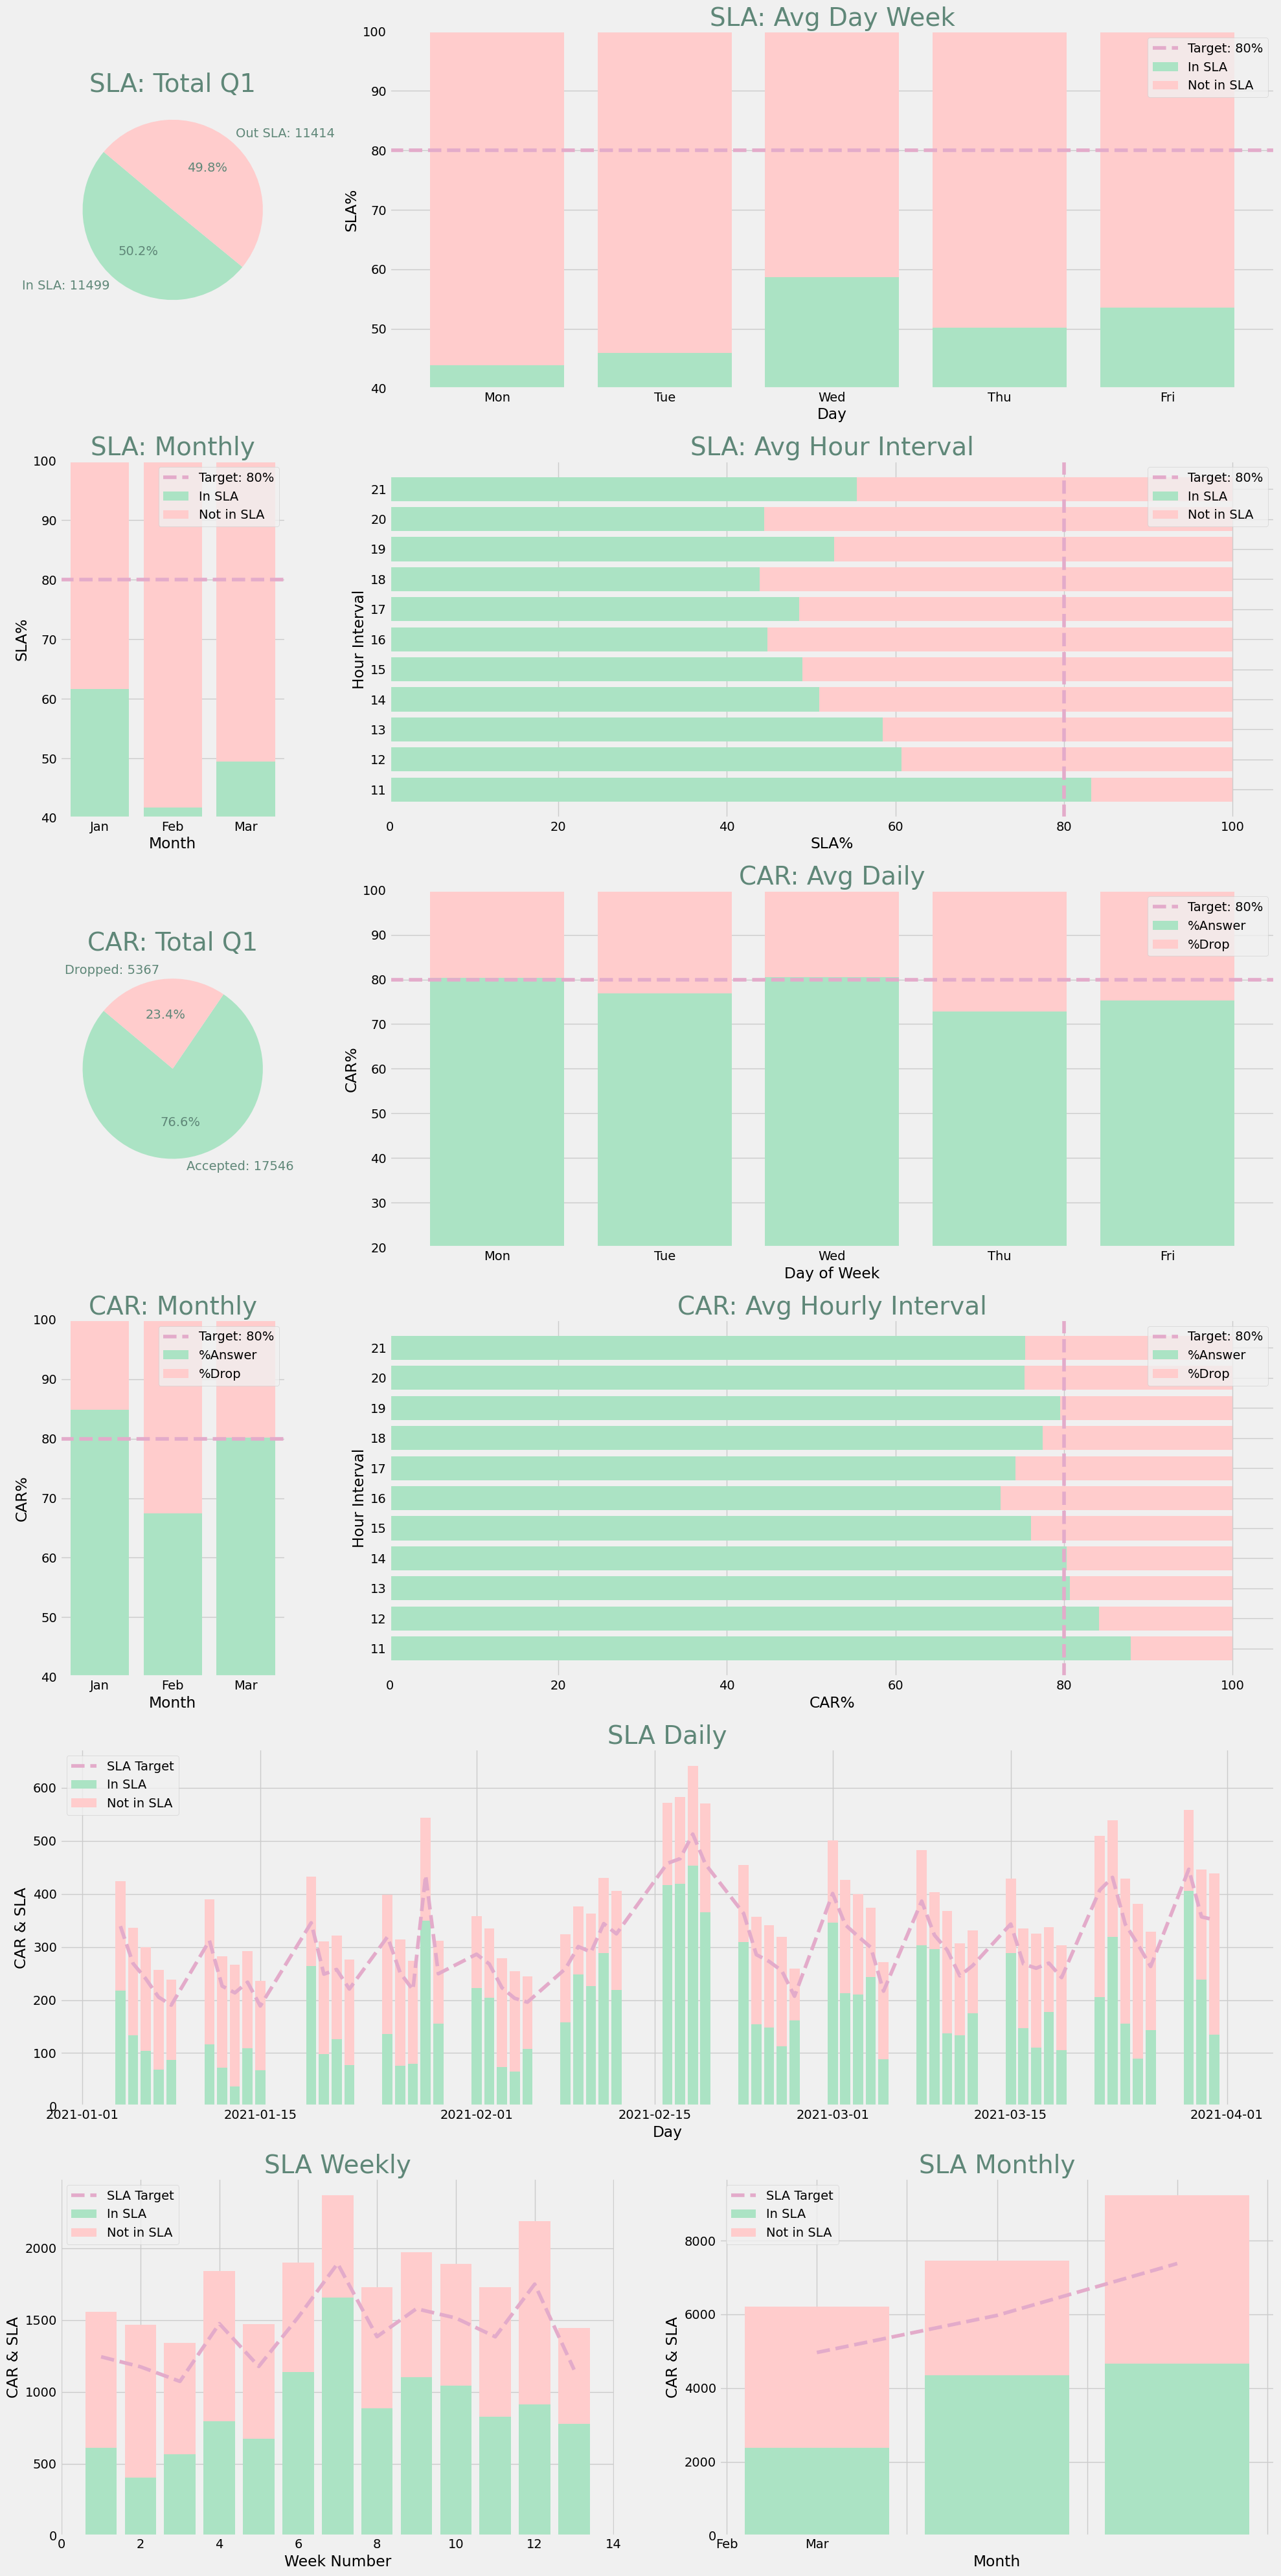

In [7]:
# Create a figure and plot our CAR and SLA Views!

fig = plt.figure(tight_layout=True, figsize=(20, 40))
gs = gridspec.GridSpec(6, 4)

# SLA Totals
ax1 = fig.add_subplot(gs[0, 0])
custom_labels = [f"In SLA: {sla_totals[0]}", f"Out SLA: {sla_totals[1]}"]
ax1.pie(sla_totals, labels=custom_labels, autopct='%1.1f%%', startangle=140, colors=[color_brand[0], color_brand[5]], textprops=fig_text_dict)
ax1.set_title('SLA: Total Q1', fontdict=titles_dict)

# SLA Monthly
ax2 = fig.add_subplot(gs[1,0])
ax2.bar(sla_month.index, sla_month['%_Y'], color=color_brand[0], label='In SLA')
ax2.bar(sla_month.index, sla_month['%_N'], bottom=sla_month['%_Y'], color=color_brand[5], label='Not in SLA')
ax2.set_title('SLA: Monthly', fontdict=titles_dict)
ax2.set_xlabel('Month')
ax2.set_ylabel('SLA%')
ax2.set_ylim(40, 100)
ax2.set_xticks(sla_month.index)
ax2.set_xticklabels(['Jan', 'Feb', 'Mar'])
ax2.axhline(y=80, color=color_brand[4], linestyle='--', label='Target: 80%')
ax2.legend()

# SLA Daily
ax3 = fig.add_subplot(gs[0, 1:])
ax3.bar(sla_day_week.index, sla_day_week['%_Y'], color=color_brand[0], label='In SLA')
ax3.bar(sla_day_week.index, sla_day_week['%_N'], bottom=sla_day_week['%_Y'], color=color_brand[5], label='Not in SLA')
ax3.set_title('SLA: Avg Day Week', fontdict=titles_dict)
ax3.set_xlabel('Day')
ax3.set_ylabel('SLA%')
ax3.set_ylim(40, 100)
ax3.set_xticks(sla_day_week.index)
ax3.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
ax3.axhline(y=80, color=color_brand[4], linestyle='--', label='Target: 80%')
ax3.legend()

# SLA Hourly
ax4 = fig.add_subplot(gs[1, 1:])
ax4.barh(sla_hour.index, sla_hour['%_Y'], color=color_brand[0], label='In SLA')
ax4.barh(sla_hour.index, sla_hour['%_N'], left=sla_hour['%_Y'], color=color_brand[5], label='Not in SLA')
ax4.set_title('SLA: Avg Hour Interval', fontdict=titles_dict)
ax4.set_xlabel('SLA%')
ax4.set_ylabel('Hour Interval')
ax4.set_yticks(sla_hour.index)
ax4.axvline(x=80, color=color_brand[4], linestyle='--', label='Target: 80%')
ax4.legend()

# CAR Totals
ax5 = fig.add_subplot(gs[2,0])
custom_labels = [f"Accepted: {car_totals[0]}", f"Dropped: {car_totals[1]}"]
ax5.pie(car_totals, labels=custom_labels, autopct='%1.1f%%', startangle=140, colors=[color_brand[0], color_brand[5]], textprops=fig_text_dict)
ax5.set_title('CAR: Total Q1', fontdict=titles_dict)

# CAR Monthly
ax6 = fig.add_subplot(gs[3,0])
ax6.bar(car_month.index, car_month['%_N'], color=color_brand[0], label='%Answer')
ax6.bar(car_month.index, car_month['%_Y'], bottom=car_month['%_N'], color=color_brand[5], label='%Drop')
ax6.set_title('CAR: Monthly', fontdict=titles_dict)
ax6.set_xlabel('Month')
ax6.set_ylabel('CAR%')
ax6.set_ylim(40, 100)
ax6.set_xticks(car_month.index)
ax6.set_xticklabels(['Jan', 'Feb', 'Mar'])
ax6.axhline(y=80, color=color_brand[4], linestyle='--', label='Target: 80%')
ax6.legend()

# CAR Daily
ax7 = fig.add_subplot(gs[2, 1:])
ax7.bar(car_day_week.index, car_day_week['%_N'], color=color_brand[0], label='%Answer')
ax7.bar(car_day_week.index, car_day_week['%_Y'], bottom=car_day_week['%_N'], color=color_brand[5], label='%Drop')
ax7.set_title('CAR: Avg Daily', fontdict=titles_dict)
ax7.set_xlabel('Day of Week')
ax7.set_ylabel('CAR%')
ax7.set_ylim(20, 100)
ax7.set_xticks(car_day_week.index)
ax7.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
ax7.axhline(y=80, color=color_brand[4], linestyle='--', label='Target: 80%')
ax7.legend()

# CAR Hourly
ax8 = fig.add_subplot(gs[3, 1:])
ax8.barh(car_hour.index, car_hour['%_N'], color=color_brand[0], label='%Answer')
ax8.barh(car_hour.index, car_hour['%_Y'], left=car_hour['%_N'], color=color_brand[5], label='%Drop')
ax8.set_title('CAR: Avg Hourly Interval', fontdict=titles_dict)
ax8.set_xlabel('CAR%')
ax8.set_ylabel('Hour Interval')
ax8.set_yticks(car_hour.index)
ax8.axvline(x=80, color=color_brand[4], linestyle='--', label='Target: 80%')
ax8.legend()
    
# CAR / SLA Daily
ax9 = fig.add_subplot(gs[4, 0:])
ax9.bar(daily_vols_car_sla.index, daily_vols_car_sla['N'], color=color_brand[0], label='In SLA')
ax9.bar(daily_vols_car_sla.index, daily_vols_car_sla['Y'], bottom=daily_vols_car_sla['N'], color=color_brand[5], label='Not in SLA')
ax9.plot(daily_vols_car_sla['sla_target'], color=color_brand[4], label='SLA Target', linestyle='--')
ax9.set_title('SLA Daily', fontdict=titles_dict)
ax9.set_xlabel('Day')
ax9.set_ylabel('CAR & SLA')
ax9.legend()

# CAR / SLA Weekly
ax10 = fig.add_subplot(gs[5, 0:2])
ax10.bar(weekly_vols_car_sla.index, weekly_vols_car_sla['N'], color=color_brand[0], label='In SLA')
ax10.bar(weekly_vols_car_sla.index, weekly_vols_car_sla['Y'], bottom=weekly_vols_car_sla['N'], color=color_brand[5], label='Not in SLA')
ax10.plot(weekly_vols_car_sla['sla_target'], color=color_brand[4], label='SLA Target', linestyle='--')
ax10.set_title('SLA Weekly', fontdict=titles_dict)
ax10.set_xlabel('Week Number')
ax10.set_ylabel('CAR & SLA')
ax10.legend()

# CAR / SLA Monthly
ax11 = fig.add_subplot(gs[5, 2:])
ax11.bar(monthly_vols_car_sla.index, monthly_vols_car_sla['N'], color=color_brand[0], label='In SLA')
ax11.bar(monthly_vols_car_sla.index, monthly_vols_car_sla['Y'], bottom=monthly_vols_car_sla['N'], color=color_brand[5], label='Not in SLA')
ax11.plot(monthly_vols_car_sla['sla_target'], color=color_brand[4], label='SLA Target', linestyle='--')
ax11.set_title('SLA Monthly', fontdict=titles_dict)
ax11.set_xlabel('Month')
ax11.set_ylabel('CAR & SLA')
ax11.set_xticklabels(['Jan', 'Feb', 'Mar'])
ax11.legend()

plt.show()

# Step 4: Analyze Call Concurrency and Agent Capacity.
### Objective: Build Dataframes to measure call concurrency (How many calls are happening at once) and Agent Capacity (How many Agents are available). <br>

**1. Data Preparation:**
- Filter out rows with missing values in the 'talk_time_started' column. 🧹
- Select relevant columns for further analysis.
- Create 'start' and 'stop' columns to represent call and talk time intervals.
- Concatenate call and talk time series along with the status series.

**2. Sorting and Counter Calculation:**
- Sort the DataFrame by call time.
- Calculate the cumulative counter based on 'start' and 'stop' status.

**3. Hourly Concurrency Analysis:**
- Group by hour and calculate the 75th percentile of the counter. 📈
- Extract the week number from call time and group by week and hour.
- Pivot the DataFrame to create a heatmap-ready structure for weekly hourly concurrency.

**4. Agent Capacity Analysis:**
- Group by hour and calculate the number of unique agents. 🕵️‍♂️
- Group by week and hour, calculate the number of unique agents for weekly analysis.

**5. Delta Calculation:**
- Concatenate hourly agent count, concurrent calls, and calculate the delta (needed_agents - actual_agents).
- Concatenate weekly hourly agent count, concurrent calls, and calculate the delta for weekly analysis.
- Pivot the DataFrame to create a heatmap-ready structure for delta analysis.

**6. Conclusion:**
- Perform a comprehensive analysis of call concurrency and agent capacity.
- Visualize hourly concurrency, agent capacity, and the delta between needed and actual agents on both daily and weekly scales.
- Utilize appropriate titles, labels, legends, and color coding for clarity. 🎨

In [8]:
# Filter out rows with missing values in 'talk_time_started'
df_rough = df_only_important.dropna(subset=['talk_time_started'])

# Select only the relevant columns
df_rough = df_rough[['call_started', 'talk_time_started']]

# Create 'start' and 'stop' columns
df_rough['start'] = 'start'
df_rough['stop'] = 'stop'

# Concatenate call and talk time series along with status series
calls_series = pd.concat([df_rough['call_started'], df_rough['talk_time_started']], ignore_index=True)
status_series = pd.concat([df_rough['start'], df_rough['stop']], ignore_index=True)
calls_concurrent = pd.concat([calls_series, status_series], axis=1)
calls_concurrent.columns = ['call_time', 'status']

# Sort the DataFrame by call time
calls_concurrent = calls_concurrent.sort_values(by='call_time')

# Calculate the cumulative counter based on 'start' and 'stop' status
calls_concurrent['counter'] = np.where(calls_concurrent['status'].eq('start'), 1, -1).cumsum()

# Group by hour and calculate the 75th percentile of the counter
calls_concurrent_hour = calls_concurrent.groupby(calls_concurrent['call_time'].dt.hour)['counter'].quantile(0.75).reset_index()

# Extract week number from call time and group by week and hour
calls_concurrent['week_number'] = calls_concurrent['call_time'].dt.isocalendar().week
calls_concurrent_week_hour = calls_concurrent.groupby(['week_number', calls_concurrent['call_time'].dt.hour])['counter'].quantile(0.75).reset_index()
calls_concurrent_week_hour = calls_concurrent_week_hour.reset_index(drop=True)

# Pivot the DataFrame to create a heatmap-ready structure
heatmap_data = calls_concurrent_week_hour.pivot(index='call_time', columns='week_number', values='counter')

# Group by hour and calculate the number of unique agents
hourly_agents = df_only_important.groupby(df_only_important['talk_time_started'].dt.hour)['agent_id'].nunique().reset_index()
hourly_agents.columns = ['hour', 'num_agents']

# Group by week and hour, calculate the number of unique agents
weekly_hourly_agents = df_only_important.groupby([df_only_important['talk_time_started'].dt.isocalendar().week, df_only_important['talk_time_started'].dt.hour])['agent_id'].nunique().reset_index()
weekly_hourly_agents.columns = ['week', 'hour', 'num_agents']


In [9]:
# Analyzing hourly agents and their delta against needed agents
# Hourly Agents
hourly_agents = df_only_important.groupby(df_only_important['talk_time_started'].dt.hour)['agent_id'].nunique().reset_index()
hourly_agents.columns = ['hour', 'num_agents']

# Weekly Hourly Agents
weekly_hourly_agents = df_only_important.groupby([df_only_important['talk_time_started'].dt.isocalendar().week, df_only_important['talk_time_started'].dt.hour])['agent_id'].nunique().reset_index()
weekly_hourly_agents.columns = ['week', 'hour', 'num_agents']

# Concatenate hourly agent data with concurrent call data
agent_delta_hour = pd.concat([hourly_agents['hour'], hourly_agents['num_agents'], calls_concurrent_hour['counter']], axis=1)
agent_delta_hour.columns = ['hour', 'actual_agents', 'needed_agents']
agent_delta_hour['delta'] = agent_delta_hour['needed_agents'] - agent_delta_hour['actual_agents']

# Concatenate weekly hourly agent data with weekly concurrent call data
agent_delta_hour_weekly = pd.concat([weekly_hourly_agents['week'], weekly_hourly_agents['hour'], weekly_hourly_agents['num_agents'], calls_concurrent_week_hour['counter']], axis=1)
agent_delta_hour_weekly.columns = ['week_number', 'hour', 'actual_agents', 'needed_agents']
agent_delta_hour_weekly['delta'] = agent_delta_hour_weekly['needed_agents'] - agent_delta_hour_weekly['actual_agents']

# Prepare data for heatmap
heatmap_delta_data = agent_delta_hour_weekly.pivot(index='hour', columns='week_number', values='delta')

## Step 5: Building HeatMaps
### Objective: Build a function to make creating & decorating Heatmaps easier. <br>

**1. Function Purpose:**
   - Create a heatmap from a 2D numpy array with row and column labels. 🗺️

**2. Parameters:**
   - `data`: A 2D numpy array of shape (M, N).
   - `row_labels`: A list or array of length M with labels for the rows.
   - `col_labels`: A list or array of length N with labels for the columns.
   - `ax`: A `matplotlib.axes.Axes` instance to plot the heatmap (optional).
   - `cbar_kw`: A dictionary with arguments to `matplotlib.Figure.colorbar` (optional).
   - `cbarlabel`: The label for the colorbar (optional).
   - `**kwargs`: Additional arguments forwarded to `imshow`.

**3. Implementation:**
   - Plot the heatmap using `ax.imshow(data, **kwargs)`.
   - Create a colorbar using `matplotlib.Figure.colorbar`.
   - Set ticks and labels for rows and columns.
   - Customize tick labels' appearance and grid lines. 🌈

### Annotation Function (`annotate_heatmap`)

**1. Function Purpose:**
   - Annotate values on a heatmap.

**2. Parameters:**
   - `im`: The AxesImage to be labeled.
   - `data`: Data used to annotate (optional).
   - `valfmt`: The format of the annotations (optional).
   - `textcolors`: A pair of colors for values above and below a threshold (optional).
   - `threshold`: Value in data units for color separation (optional).
   - `**textkw`: Additional arguments forwarded to each call to `text` for label creation.

**3. Implementation:**
   - Normalize the threshold.
   - Loop over the data and create `Text` for each "pixel."
   - Change text color based on the data value and threshold.
   - Customize text alignment and color. 🎨

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.0f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Step 6: Call Arrival Patterns & Average Handle Times.
### Objective: Refine our Data to make visualising Arrival Patterns & Handle Times easier. <br>

### Data Preparation for Call Patterns (`call_patterns`)

**1. Clean and Map Time Intervals:**
   - Extract 'rounded_time' series and drop missing values. 🕰️
   - Map unique intervals to a specified range.
   - Convert the date series to a DataFrame (`call_arrivals_15mins`).
   - Use `value_counts` to get counts for each interval category.

**2. Format x-axis Tick Labels:**
   - Convert mapped intervals to appropriate time format (hh:mm). ⏰
   - Build a list of formatted x-axis tick labels (`x_ticks_arrivals`).

### Handle Times Analysis (`df_handle_times`, `handle_time_reason`, `handle_time_agent`)

**1. Extract Relevant Columns:**
   - Select relevant columns ('detail_reason', 'agent_id', 'talk_time', 'wrap_time') from `df_only_important`.
   - Calculate the total handle time by summing 'talk_time' and 'wrap_time'. 🔄

**2. Reason-wise Handle Time Analysis:**
   - Group by 'detail_reason' and aggregate metrics like maximum agent ID, average talk time, average wrap time, and average total handle time.
   - Convert 'detail_reason' to a categorical type.

**3. Agent-wise Handle Time Analysis:**
   - Group by 'agent_id' and aggregate similar metrics as in reason-wise analysis.
   - Convert 'agent_id' to a categorical type. 🕵️‍♂️

**Note:** Commented-out lines related to max/min handle times are present in the code but not used in the final output.

In [11]:
# Processing call arrival intervals

# Extract and preprocess call arrival times
call_patterns = df_only_important['rounded_time']
call_patterns = call_patterns.dropna()

# Create unique call intervals
unique_call_intervals = sorted(call_patterns.unique().tolist())

# Define time range and step for mapping intervals
start = 11.0
end = 22.0
step = 0.25

# Map intervals to a specified range
mapped_ints_intervals = [i for i in np.arange(start, end + step, step)]

# Convert the date series to a DataFrame
call_patterns = call_patterns.replace(dict(zip(unique_call_intervals, mapped_ints_intervals)))

# Convert the date series to a DataFrame
call_arrivals_15mins = pd.DataFrame({'interval': call_patterns})

# # Use value_counts to get counts for each category
call_arrivals_15mins = call_arrivals_15mins.groupby('interval').size().reset_index(name='mean_count')

# # # Convert counts to a DataFrame with appropriate column names
call_arrivals_15mins = call_arrivals_15mins.reset_index()
call_arrivals_15mins = call_arrivals_15mins.sort_values(by='interval')
call_arrivals_15mins['avg_interval'] = call_arrivals_15mins['mean_count'] / 61

/tmp/ipykernel_18/753291263.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  call_patterns = call_patterns.replace(dict(zip(unique_call_intervals, mapped_ints_intervals)))


In [12]:
call_arrivals_15mins.head()

,index,interval,mean_count,avg_interval
0,0,11.00,18,0.295082
1,1,11.25,26,0.426230
2,2,11.50,35,0.573770
3,3,11.75,48,0.786885
4,4,12.00,160,2.622951


In [13]:
# Mapping and formatting intervals for x-axis ticks

# Convert mapped intervals to strings
mapped_ints_intervals = [str(i) for i in mapped_ints_intervals]
x_ticks_arrivals = []
# Iterate over mapped intervals and format for display
for item in mapped_ints_intervals:
    item_split = item.split('.')
    if item_split[1] == '0':
        x_ticks_arrivals.append(f'{item_split[0]}:00')
    elif item_split[1] == '25':
        x_ticks_arrivals.append(f'{item_split[0]}:15')
    elif item_split[1] == '5':
        x_ticks_arrivals.append(f'{item_split[0]}:30')
    elif item_split[1] == '75':
        x_ticks_arrivals.append(f'{item_split[0]}:45')

In [14]:
# Extract relevant columns for handle times analysis
df_handle_times = df_only_important[['detail_reason', 'agent_id', 'talk_time', 'wrap_time', 'service_level_reached']]

# Calculate total handle time by summing talk_time and wrap_time
df_handle_times['total_handle'] = df_only_important['talk_time'] + df_only_important['wrap_time']

# Group by 'detail_reason' and calculate aggregated statistics for handle times
handle_time_reason = df_handle_times.groupby('detail_reason').agg({'agent_id':'max', 'talk_time': 'mean', 'talk_time': 'mean', 'wrap_time': 'mean', 'total_handle': 'mean', 'service_level_reached' : 'count'}).reset_index()
# max_handle_time_reason = df_handle_times.groupby('detail_reason').max().reset_index()
# min_handle_time_reason = df_handle_times.groupby('detail_reason').min().reset_index()
# handle_time_reason['max_total'] = max_handle_time_reason['total_handle']
# handle_time_reason['min_total'] = min_handle_time_reason['total_handle']

# Group by 'agent_id' and calculate aggregated statistics for handle times
handle_time_agent = df_handle_times.groupby('agent_id').agg({'detail_reason':'max', 'talk_time': 'mean', 'talk_time': 'mean', 'wrap_time': 'mean', 'total_handle': 'mean'}).reset_index()
# max_handle_time_agent = df_handle_times.groupby('agent_id').max().reset_index()
# min_handle_time_agent = df_handle_times.groupby('agent_id').min().reset_index()
# handle_time_agent['max_total'] = handle_time_agent['total_handle']
# handle_time_agent['min_total'] = handle_time_agent['total_handle']

# Convert 'agent_id' and 'detail_reason' to categorical data type
handle_time_agent['agent_id'] = handle_time_agent['agent_id'].astype('category')
handle_time_reason['detail_reason'] = handle_time_reason['detail_reason'].astype('category')

/tmp/ipykernel_18/3362212747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_handle_times['total_handle'] = df_only_important['talk_time'] + df_only_important['wrap_time']


# Step 7: Forecasting 12 Months Calls Volumes

### Objective: Use Time Series Forecasting Model to forecast the Next 12 Months of call Volumes 📈 <br>

**1. Group Data for Time Series:**
   - Group `df_only_important` by date and calculate the size to create `projection_data`.

**2. Handle Outliers in the Time Series:**
   - Calculate the 75th percentile and mean of the time series. 📊
   - Cap values in `projection_data` above the 75th percentile by setting them to the 75th percentile.

**3. Fill Weekends with Mean Values:**
   - Create a date range from 'start_date' to 'end_date'.
   - Identify weekend dates in the range.
   - Create a DataFrame `add_on` with weekend dates and mean projection values.
   - Concatenate `add_on` to `projection_data` to fill weekends with mean values. 🗓️

**4. Format and Sort Projection Data:**
   - Convert 'date' to datetime in `projection_data`.
   - Sort `projection_data` by 'date' and reset the index.

### Prophet Time Series Forecasting

**1. Define Model and Fit:**
   - Initialize a Prophet model with linear growth and seasonality prior scale.
   - Fit the model using `projection_data`.

**2. Generate Future Dates:**
   - Create a DataFrame `future` with future dates using `make_future_dataframe`.

**3. Generate Forecast:**
   - Use the fitted model to generate a forecast for the future dates.

**4. Extract Relevant Forecast Columns:**
   - Extract relevant columns ('ds', 'yhat', 'yhat_lower', 'yhat_upper') from the forecast for further analysis (`forecast_only_important`).

**Note:** The seasonality prior scale is set to 10.0, and other Prophet parameters can be adjusted based on the specific characteristics of the time series data. 🕰️


In [15]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics

# Group data by date and calculate the count of occurrences
projection_data = df_only_important.groupby(df_only_important['date']).size().reset_index(name='y')

# Calculate the 75th percentile and mean of the 'y' values
projection_75th = projection_data['y'].quantile(0.75)
projection_mean = projection_data['y'].mean()

# Set values in 'y' column above the 75th percentile to the 75th percentile
projection_data.loc[projection_data['y'] > projection_75th, 'y'] = projection_75th

# Define start and end dates for the analysis
start_date = '2021-01-04'
end_date = '2021-03-31'

# Create a date range from start to end date with a frequency of one day
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Select weekend dates from the date range
weekend_dates = date_range[date_range.dayofweek.isin([5, 6])]

# Create a DataFrame with weekend dates and the mean value
add_on = pd.DataFrame({'date': weekend_dates, 'y': [projection_mean] * len(weekend_dates)})

# Concatenate the original projection_data with the add_on DataFrame
projection_data = pd.concat([projection_data, add_on], ignore_index=True)

# Convert 'date' column to datetime
projection_data['date'] = pd.to_datetime(projection_data['date'])  # Convert 'date' to datetime

# Sort the DataFrame by 'date' and reset the index
projection_data.sort_values(by='date', inplace=True)
projection_data.reset_index(drop=True, inplace=True)

# Rename columns to use Prophet's conventions
projection_data.columns = ['ds', 'y']

# Create a Prophet model with linear growth and a specified seasonality prior scale
m = Prophet(growth='linear', seasonality_prior_scale=10.0)
# Fit the model using the prepared projection_data
m.fit(projection_data)
# Generate a DataFrame for future dates
future = m.make_future_dataframe(periods=365)
# Make predictions for future dates using the trained model
forecast = m.predict(future)
# Select relevant columns from the forecast DataFrame
forecast_only_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

10:18:25 - cmdstanpy - INFO - Chain [1] start processing
10:18:26 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Based on our Projections from Prophet figure out Monthly agent needs & rough Financial forecast
import math

# Add a col to total_resons df calculating the proportion of Total each detail reason represents
total_reasons_ = handle_time_reason['service_level_reached'].sum()
handle_time_reason['%share'] = handle_time_reason['service_level_reached'] / total_reasons_

# Average weighted AHT
handle_time_reason['weighted_aht'] =  handle_time_reason['total_handle'] * handle_time_reason['%share']
total_weighted_aht = handle_time_reason['weighted_aht'].sum()

agents_projections_daily = forecast_only_important
agents_projections_daily.head()

agents_projections_daily['total_seconds_work'] = agents_projections_daily['yhat'] * total_weighted_aht

sla_ = 0.85
monthly_loaded_cost = 4792.77
# Assuming an 8 Hour working shit, how many agents needed to cover to work 
agents_projections_daily['agents_needed_bare'] = (agents_projections_daily['total_seconds_work'] / (3600 * sla_) / 8)
agents_projections_daily['agents_needed_w_shrinkage'] = agents_projections_daily['agents_needed_bare']  * 1.2
agents_projections_daily['agents_needed_w_shrinkage_rounded'] = agents_projections_daily['agents_needed_w_shrinkage'].apply(lambda x: math.ceil(x))

# handle_time_reason = df_handle_times.groupby('detail_reason').agg({'agent_id':'max', 'talk_time': 'mean', 'talk_time': 'mean', 'wrap_time': 'mean', 'total_handle': 'mean', 'service_level_reached' : 'count'}).reset_index()
agents_projections_monthly = agents_projections_daily.groupby(pd.Grouper(key='ds', freq='M')).agg({"agents_needed_bare" : "max", "agents_needed_w_shrinkage" : "max", "agents_needed_w_shrinkage_rounded" : "max", "yhat" : "sum"})
agents_projections_monthly['cost_bsl'] = agents_projections_monthly['agents_needed_w_shrinkage_rounded'] * monthly_loaded_cost

/tmp/ipykernel_18/237142293.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agents_projections_daily['total_seconds_work'] = agents_projections_daily['yhat'] * total_weighted_aht
/tmp/ipykernel_18/237142293.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agents_projections_daily['agents_needed_bare'] = (agents_projections_daily['total_seconds_work'] / (3600 * sla_) / 8)
/tmp/ipykernel_18/237142293.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [17]:
# Data preparation for Projections & Costs
x = agents_projections_monthly.index.tolist()
y = agents_projections_monthly['cost_bsl'].tolist()
xlabels = [item.strftime('%b') for item in agents_projections_monthly.index.tolist()]
unique_costs_ = agents_projections_monthly.drop_duplicates(subset='cost_bsl', keep='first')
x_costs = unique_costs_.index.tolist()
y_costs = unique_costs_['cost_bsl'].tolist()
labels_costs = [f"${str(item)[:2]}k" for item in y_costs]

# Step 8: Visualizing Heatmaps, Agent Handle Times, and Time Series Forecast

### Objective: Use the Dataframes built to visualize Call Arrival Patterns, Handle Times & Forecast Model 📊 <br>

**1. Concurrent Calls per Hour:**
   - Create a HeatMap for concurrent calls per hour across different weeks.
   - Use a reversed RdYlGn color map to emphasize variations. 🌈
   - Include a color bar to show the intensity of concurrent calls.
   - Annotate the HeatMap for additional context.

**2. Delta: Actuals vs Needed Agents:**
   - Generate a HeatMap illustrating the difference between actual and needed agents per hour.
   - Utilize a reversed RdYlGn color map and annotate for clear visibility.
   - Include a color bar for quick reference.

**3. Call Arrivals Distribution:**
   - Display a horizontal bar chart for call arrivals distribution over 15-minute intervals.
   - Use custom x-tick labels for improved readability. 📊
   - Add titles and labels to enhance interpretation.

**4. Average Handle Times: Agent and Reason:**
   - Present two horizontal bar charts for average talk time and wrap time for agents and reasons.
   - Use distinct colors for talk time and wrap time, and include legends for clarity.

**5. Time Series Forecasting:**
   - Plot actual call volume against the forecast for the upcoming 12 months.
   - Visualize the prediction, lower and upper bounds, and highlight a specific date for reference. 📈
   - Provide labels and titles for a comprehensive understanding.

**Note:** The color palette and style can be customized based on preferences and visual consistency. 🎨


/tmp/ipykernel_18/114610655.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  COLOR_REVERSED = plt.cm.get_cmap("RdYlGn").reversed()
/opt/conda/lib/python3.10/site-packages/matplotlib/colors.py:1304: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/conda/lib/python3.10/site-packages/matplotlib/colors.py:1311: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/opt/conda/lib/python3.10/site-packages/matplotlib/ticker.py:374: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)
/tmp/ipykernel_18/114610655.py:91: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was

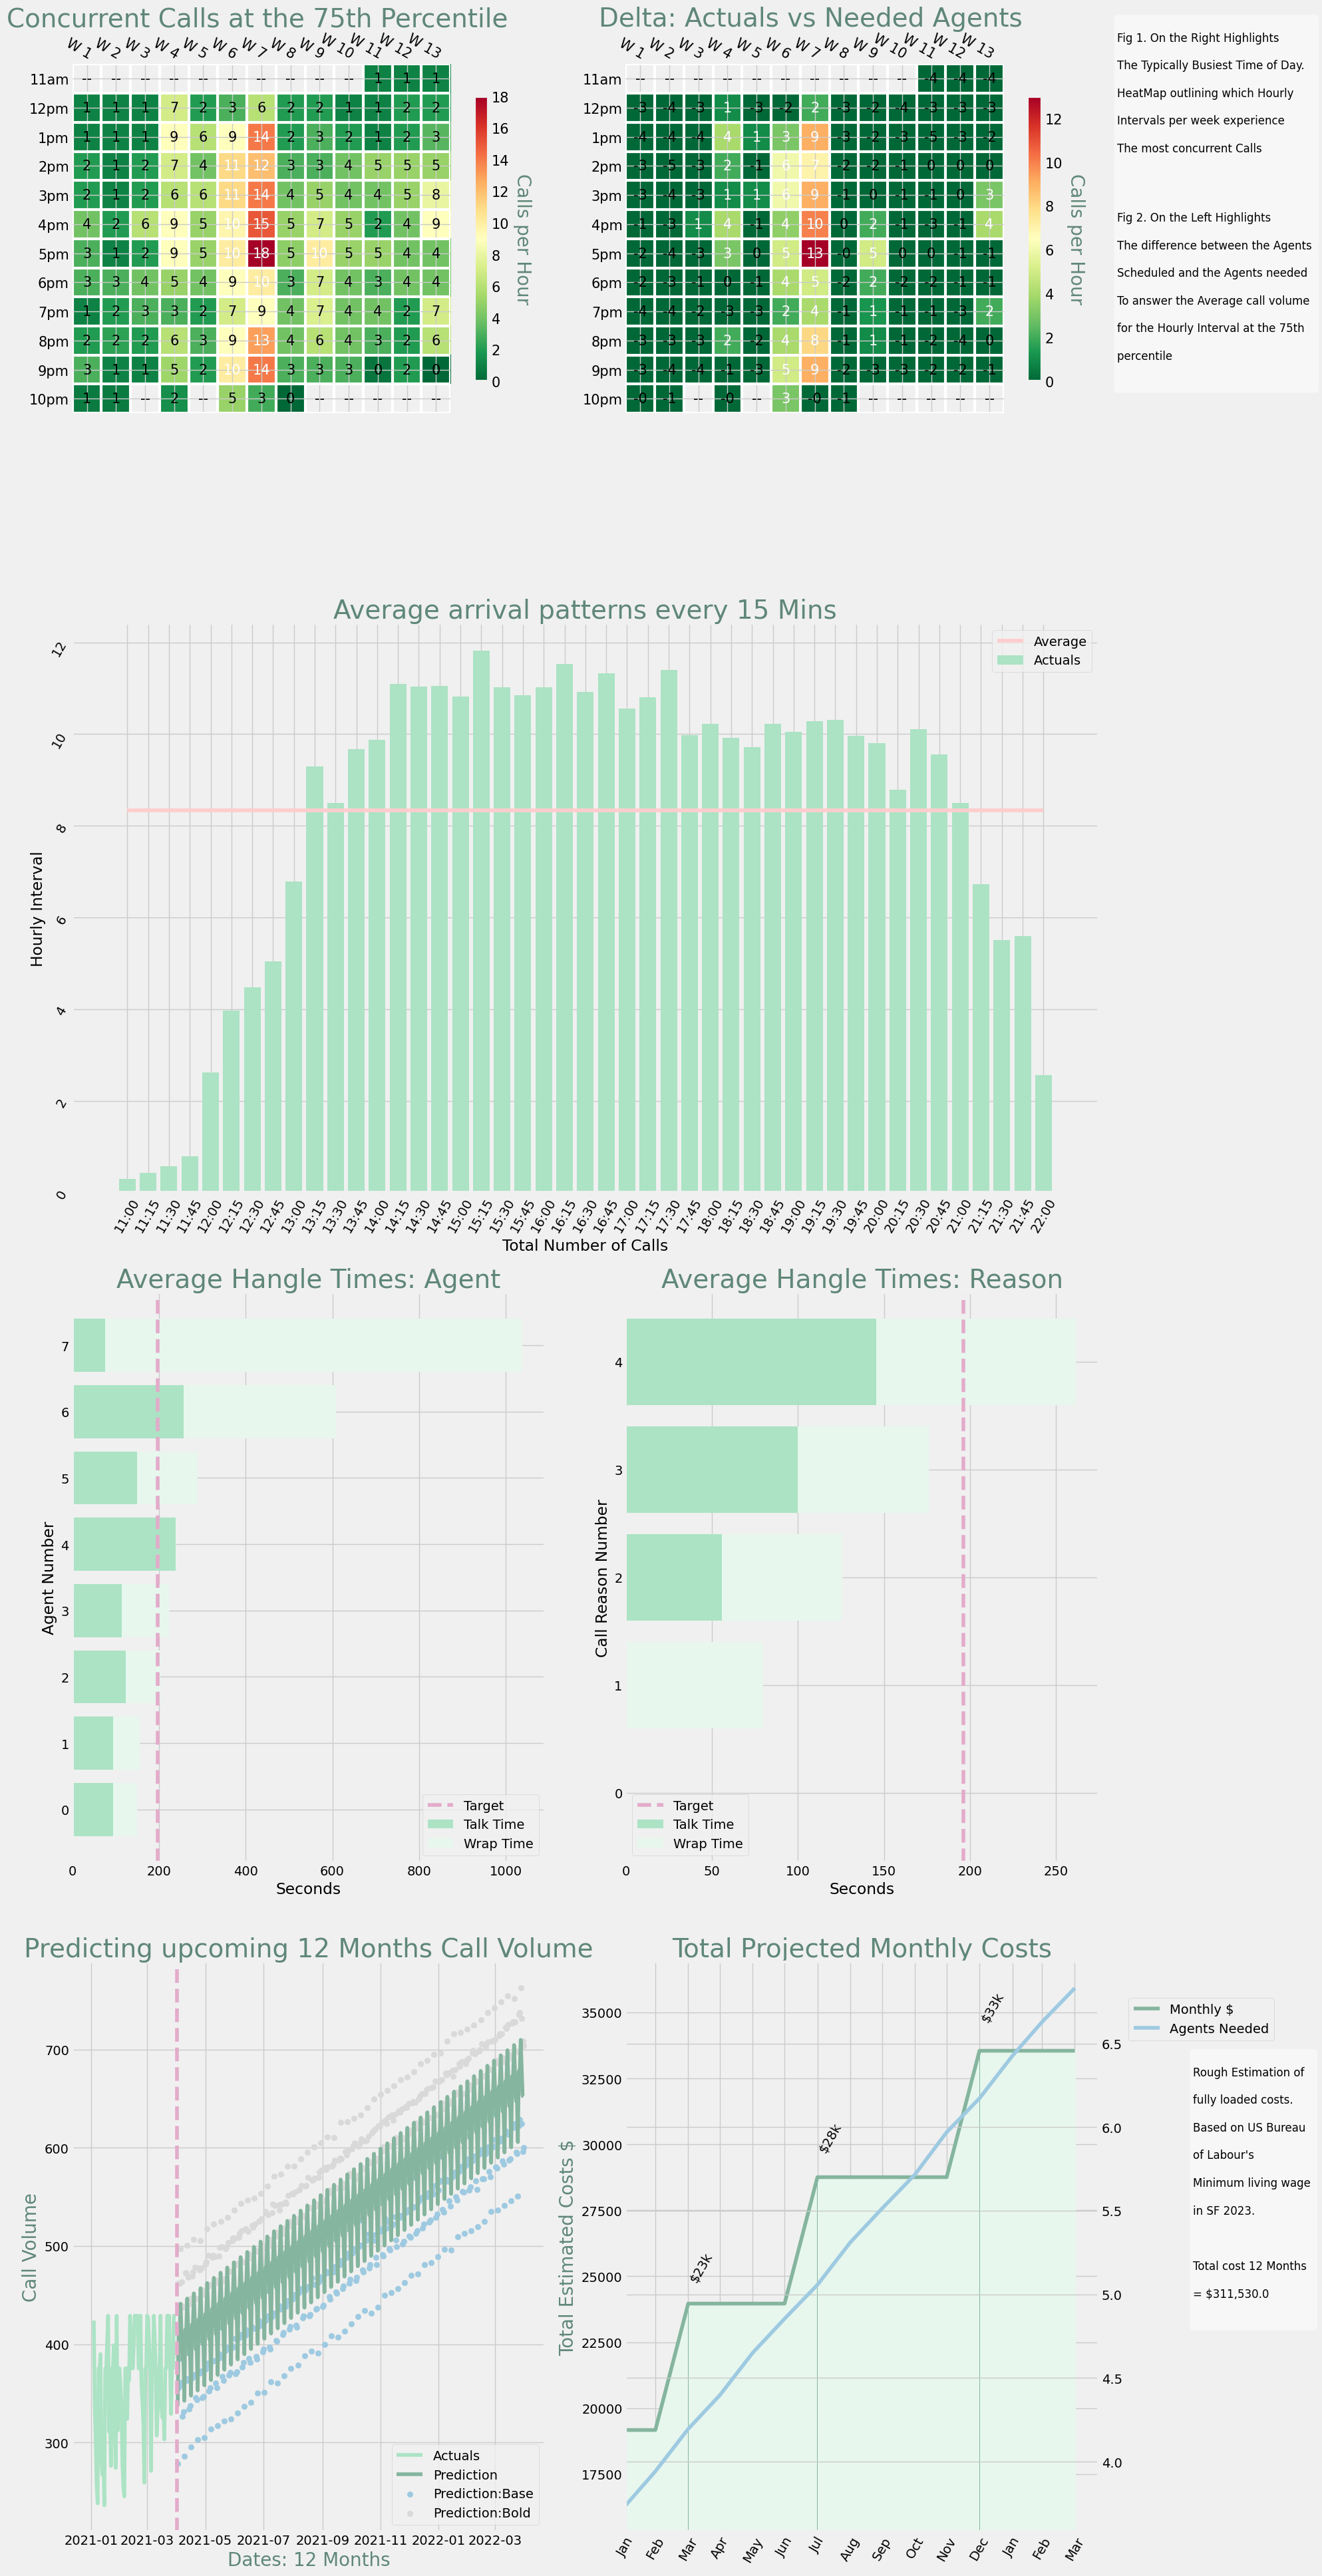

In [18]:
# Define constants for concurrent weeks, hours, and color map
CONCURRENT_WEEKS = ['W 1', 'W 2', 'W 3', 'W 4', 'W 5', 'W 6', 'W 7', 'W 8', 'W 9', 'W 10', 'W 11', 'W 12', 'W 13']
CONCURRENT_HOURS = ['11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm']
COLOR_REVERSED = plt.cm.get_cmap("RdYlGn").reversed()

# Text for the first subplot
text1 = """
Fig 1. On the Right Highlights \n
The Typically Busiest Time of Day. \n
HeatMap outlining which Hourly \n 
Intervals per week experience \n
The most concurrent Calls \n
\n \n 
Fig 2. On the Left Highlights \n
The difference between the Agents \n
Scheduled and the Agents needed \n 
To answer the Average call volume \n 
for the Hourly Interval at the 75th \n
percentile \n
"""

# Create a figure with a specified layout and size
fig = plt.figure(figsize=(20, 40))
gs = gridspec.GridSpec(4, 2)

# Subplot 1: HeatMap Concurrent Calls per Hour
ax1 = fig.add_subplot(gs[0, 0])

im1, cbar1 = heatmap(heatmap_data, CONCURRENT_HOURS, CONCURRENT_WEEKS, ax=ax1,
                     cmap=COLOR_REVERSED, cbarlabel="Concurrent Calls", vmin=0, cbar_kw={'shrink': 0.5})
texts1 = annotate_heatmap(im1, size=15)
ax1.set_title('Concurrent Calls at the 75th Percentile ', fontdict=titles_dict)
ax1.tick_params(axis='both', which='both', labelsize=15)
cbar1.set_label("Calls per Hour", fontdict=sub_title_dict)
cbar1.ax.tick_params(axis='both', labelsize=15)

# Subplot 2: HeatMap Actual Agents Delta
ax2 = fig.add_subplot(gs[0, 1])
im2, cbar2 = heatmap(heatmap_delta_data, CONCURRENT_HOURS, CONCURRENT_WEEKS, ax=ax2,
                     cmap=COLOR_REVERSED, cbarlabel="Concurrent Calls", vmin=0, cbar_kw={'shrink': 0.5})
texts2 = annotate_heatmap(im2, size=15, threshold=0)
ax2.set_title('Delta: Actuals vs Needed Agents ', fontdict=titles_dict)
ax2.tick_params(axis='both', which='both', labelsize=15)
cbar2.set_label("Calls per Hour", fontdict=sub_title_dict)
cbar2.ax.tick_params(axis='both', labelsize=15)

bbox_1 = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax2.text(1.3, 0.6, text1, ha='left', va='center', transform=ax2.transAxes, bbox=bbox_1, fontsize=12)

# Subplot 3: Bar Plot for Call Arrivals
ax3 = fig.add_subplot(gs[1, 0:])
ax3.bar(x_ticks_arrivals, 'avg_interval', data=call_arrivals_15mins, color=color_brand[0], label='Actuals')
avg = call_arrivals_15mins['avg_interval'].mean()
avg_data_ = [avg for item in range(len(call_arrivals_15mins['avg_interval'].tolist()))]
ax3.plot(x_ticks_arrivals, avg_data_, color= color_brand[5], label='Average')
ax3.set_title('Average arrival patterns every 15 Mins', fontdict=titles_dict) 
ax3.set_xlabel('Total Number of Calls') 
ax3.set_ylabel('Hourly Interval') 
ax3.tick_params(axis='both', which='both', labelsize=14, rotation=60)
ax3.legend()

# Subplot 4: Horizontal Bar Plot for Handle Times - Agent
avg_weighted_ = handle_time_reason['weighted_aht'].sum()

ax4 = fig.add_subplot(gs[2, 0])
bar_positions = range(len(handle_time_agent['agent_id']))
handle_time_agent = handle_time_agent.sort_values(by='total_handle')
ax4.barh(bar_positions, handle_time_agent['talk_time'], color=  color_brand[0], label='Talk Time')
ax4.barh(bar_positions, handle_time_agent['wrap_time'], left=handle_time_agent['talk_time'],color=  color_brand[1], label='Wrap Time')
ax4.axvline(x=avg_weighted_, color=  color_brand[4], linestyle='--', label='Target')
ax4.set_title('Average Hangle Times: Agent', fontdict=titles_dict)
ax4.set_xlabel('Seconds')
ax4.set_ylabel('Agent Number')
ax4.legend()

# Subplot 5: Horizontl Bar Plot for Handle Times - Reason
ax5 = fig.add_subplot(gs[2, 1])
handle_time_reason = handle_time_reason.sort_values(by='total_handle')
bar_positions = range(len(handle_time_reason['detail_reason']))
ax5.barh(bar_positions, handle_time_reason['talk_time'], color=  color_brand[0], label='Talk Time')
ax5.barh(bar_positions, handle_time_reason['wrap_time'], left=handle_time_reason['talk_time'],color=  color_brand[1], label='Wrap Time')
ax5.axvline(x=avg_weighted_, color=  color_brand[4], linestyle='--', label='Target')
ax5.set_title('Average Hangle Times: Reason', fontdict=titles_dict)
ax5.set_xlabel('Seconds')
ax5.set_ylabel('Call Reason Number')
ax5.legend()

# Subplot 6: Line Plot for Call Volume Prediction
ax6 = fig.add_subplot(gs[3, 0])
line_date = pd.to_datetime('2021-04-01')
ax6.plot('ds', 'y', data=projection_data, color=  color_brand[0], label='Actuals')
ax6.plot('ds', 'yhat', data=forecast_only_important[forecast_only_important['ds'] > line_date], color=  color_brand[3], label='Prediction')
ax6.scatter('ds', 'yhat_lower', data=forecast_only_important[forecast_only_important['ds'] > line_date], color=  color_brand[8], label='Prediction:Base')
ax6.scatter('ds', 'yhat_upper', data=forecast_only_important[forecast_only_important['ds'] > line_date], color=  color_brand[9], label='Prediction:Bold')
ax6.axvline(line_date, color=  color_brand[4], ls='--')
ax6.set_xlabel('Dates: 12 Months', fontdict=sub_title_dict)
ax6.set_ylabel('Call Volume', fontdict=sub_title_dict)
ax6.set_title('Predicting upcoming 12 Months Call Volume', fontdict=titles_dict)
ax6.legend()

# Subplot 7: Weeky Total Calls Next 12 Months


ax7 = fig.add_subplot(gs[3, 1])
# Plot the line
line_1 = ax7.plot(x, y, label='Monthly $', color=  color_brand[3])
bars = ax7.bar(x, y, color=  color_brand[1], width=2)
ax7.fill_between(x, y, color=  color_brand[1])

scatters = ax7.bar(x_costs, y_costs, color=  color_brand[3])
for index, scatter in enumerate(scatters):
    ax7.annotate(f'{labels_costs[index]}', xy=(scatter.get_x(), scatter.get_height() * 1.03), rotation=60, ha='left', va='bottom')

ax7.set_xlim(x[0])
ax7.set_ylim(y_costs[0] * 0.8, y_costs[-1] * 1.1)

ax7.set_xticks(x)
ax7.set_xticklabels(xlabels, rotation=60)
ax7.tick_params(axis='both', which='both', labelsize=14)

ax7.set_ylabel('Total Estimated Costs $', fontdict=sub_title_dict)
ax7.set_title('Total Projected Monthly Costs', fontdict=titles_dict)

ax8 = ax7.twinx()
line_2 = ax8.plot(x, agents_projections_monthly['agents_needed_w_shrinkage'].tolist(), label="Agents Needed", color=  color_brand[8])

lines = line_1 + line_2
labels = [line.get_label() for line in lines]
ax7.legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.9))

formatted_sum_12_month = '{:,}'.format(round(sum(y[:12]), 0))

text_7 = f'''
Rough Estimation of \n
fully loaded costs.\n
Based on US Bureau \n
of Labour's \n
Minimum living wage \n
in SF 2023. \n
\n
Total cost 12 Months \n
= ${formatted_sum_12_month} \n
'''
bbox_2 = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax7.text(1.20, 0.6, text_7, ha='left', va='center', transform=ax7.transAxes, bbox=bbox_2, fontsize=12)

# Adjust layout and display the figure
fig.tight_layout()
plt.show()

# Project Conclusion 🎉📊

#### Throughout this project, we embarked on a journey to gain deeper insights into the performance of our contact center. From transforming raw CSV data into visually insightful graphs and plots, we have uncovered valuable information that can inform decision-making.

**Call Acceptance Rate and Service Level:** By calculating and visualizing the Call Acceptance Rate (CAR) and Service Level Agreement (SLA) over different time periods, we gained a clear understanding of our performance in terms of call handling efficiency.

**Call Concurrency & Capacity:** Our exploration into call concurrency provided a nuanced understanding of our capacity to handle multiple calls simultaneously. This was further visualized through a Capacity Heat Map, shedding light on potential bottlenecks and areas for improvement.

**Future Call Need:** Leveraging the power of Prophet's Time Series Forecasting Models, we created a simple yet effective projection model to predict future call volumes. This predictive capability equips us with the foresight to proactively manage resources and optimize our contact center's performance.

In conclusion, this project has not only provided us with valuable insights but has also equipped us with the tools and methodologies to continuously monitor and improve our contact center's performance. As we move forward, we will leverage these insights to drive strategic decision-making and enhance the overall customer experience.